<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [15]:
!pip install --break-system-packages torch torchaudio numpy matplotlib pandas seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [43]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchaudio.transforms as T

%matplotlib inline

# assert torch.__version__.startswith("1.8.0")
# assert torchaudio.__version__ == "0.8.0"

device = "cuda:0"

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

- Скачайте датасет с [диска](https://disk.yandex.ru/d/LXmjlqdXsgseoQ) c и распакуйте в папку `./data`.
- Положите разархивированные данные рядом с юпитерской тетрадкой. 

In [17]:
# link = 'https://disk.yandex.ru/d/LXmjlqdXsgseoQ' # Можно перейти по ссылке и скачать вручную

# import requests
# url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={link}"
# response = requests.get(url)
# download_url = response.json()["href"]

# with open("data.zip", "wb") as file:
#     download_response = requests.get(download_url, stream=True)
#     for chunk in download_response.iter_content(chunk_size=1024):
#         if chunk:
#             file.write(chunk)
#             file.flush()
            
# ! unzip data.zip

- Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

- С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.

In [18]:
# классы данных
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [19]:
class AudioDataset(Dataset):
    def __init__(
        self,
        path_to_csv: str,
        path_to_folder: str,
        pad_size: int = 384000,
        sr: int = 44100,
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        row = self.csv.iloc[index]
        audio_id = row["ID"]
        class_name = row["Class"]
        label = self.class_to_idx[class_name]

        file_path = os.path.join(self.path_to_folder, f"{audio_id}.wav")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Файл {file_path} не найден")
        
        torchaudio.set_audio_backend("sox_io")
        waveform, sr = torchaudio.load(file_path)

        if waveform.ndim == 2:
            original_length = waveform.shape[1]
            waveform = waveform[0]
        else:
            original_length = waveform.shape[0]

        waveform = waveform.squeeze(0)

        if original_length < self.pad_size:
            pad_amount = self.pad_size - original_length
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
        
        return {"x": waveform, "y": label, "len": original_length}

    def __len__(self):
        return self.csv.shape[0]

In [20]:
# создадим датасеты
train_dataset = AudioDataset("./data/train_part.csv", "./data/data")
val_dataset = AudioDataset("./data/val_part.csv", "./data/data")

In [21]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [22]:
# проверим возращаемые значения __getitem__

item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

/tmp/ipykernel_156625/268887392.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


/tmp/ipykernel_156625/268887392.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


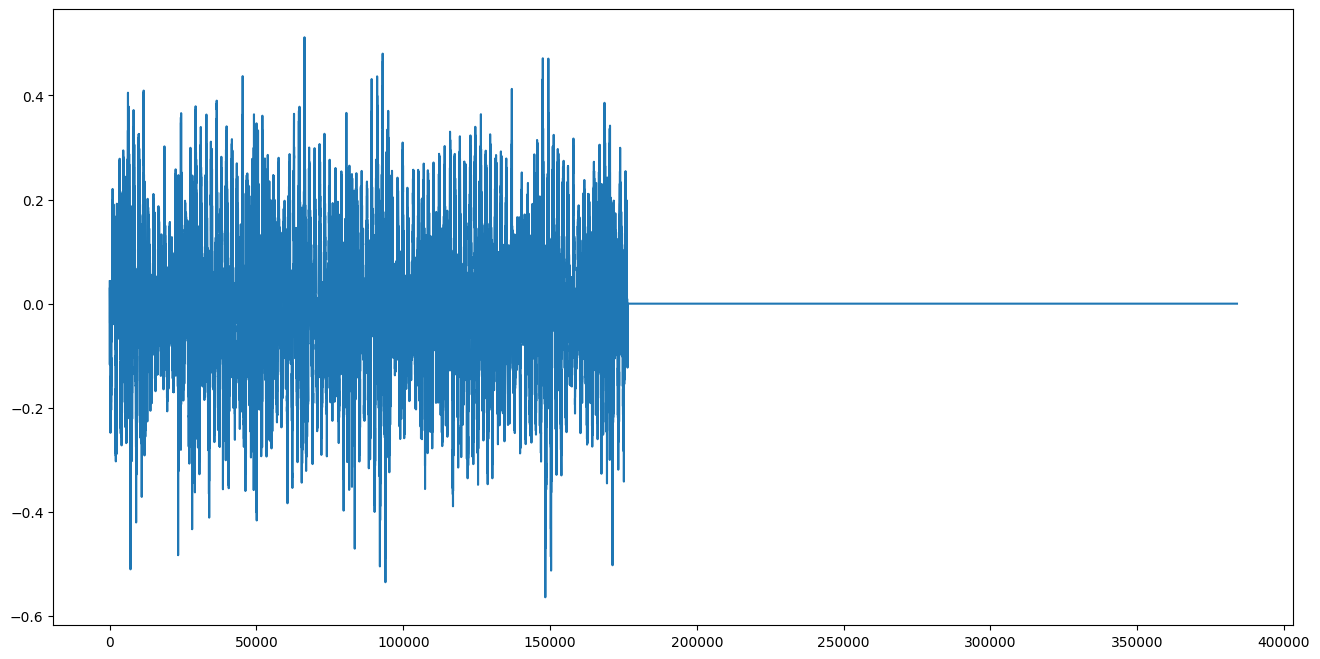

In [23]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [24]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True
)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_raw.png" height="500">
</center>

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [25]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
        dropout_first=0.2,   # dropout для first_mlp
        dropout_final=0.5,   # dropout для final_mlp
        dropout_rnn=0.3,     # dropout для LSTM (работает, если num_layers > 1)
    ) -> None:
        super().__init__()
        self.window_length = window_length
        self.hop_length = hop_length

        # Первый MLP: применяем Dropout после каждого ReLU для регуляризации
        self.first_mlp = nn.Sequential(
            nn.Linear(window_length, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_first),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_first),
            nn.Linear(64, 16)
        )
        
        # LSTM с dropout (параметр dropout активен, если num_layers > 1)
        self.rnn = nn.LSTM(
            input_size=16,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rnn if num_layers > 1 else 0.0
        )

        # Финальный MLP с dropout для регуляризации
        self.final_mlp = nn.Sequential(
            nn.Linear(2 * hidden * num_layers, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_final),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, lens) -> torch.Tensor:
        # Разбиваем сигнал на окна: (B, NUM_WINDOWS, window_length)
        batch_windows = x.unfold(dimension=1, size=self.window_length, step=self.hop_length)
        B, num_windows, window_length = batch_windows.shape

        # Преобразуем окна для первого MLP: (B * NUM_WINDOWS, window_length)
        windows_flat = batch_windows.contiguous().view(-1, window_length)
        windows_features = self.first_mlp(windows_flat)  # (B * NUM_WINDOWS, 16)
        windows_features = windows_features.view(B, num_windows, -1)  # (B, NUM_WINDOWS, 16)

        # Передаём последовательность в LSTM
        lstm_out, (h_n, c_n) = self.rnn(windows_features)
        # h_n имеет форму (num_layers * num_directions, B, hidden)
        h_n = h_n.transpose(0, 1)  # (B, num_layers * num_directions, hidden)
        hidden_flattened = h_n.reshape(B, -1)  # (B, 2 * hidden * num_layers)

        logits = self.final_mlp(hidden_flattened)
        return logits


Обучим получившуюся модель.

In [26]:
def train_audio_clfr(
    model,
    optimizer,
    train_dataloader,
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None,
    augmentation=None,
    num_epochs=10,
    device="cuda:0",
    verbose_num_iters=10,
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        epoch_loss_sum = 0.0
        epoch_acc_sum = 0.0
        num_batches = 0

        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            pred_cls = probs.argmax(dim=-1)
            batch_acc = (pred_cls == y).float().mean().item()
            train_accuracies.append(batch_acc)

            epoch_loss_sum += loss.item()
            epoch_acc_sum += batch_acc
            num_batches += 1
            iter_i += 1

            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                print(f"Epoch {epoch+1}, Iteration {iter_i} - Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}")
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train Loss")
                plt.plot(np.arange(iter_i), train_losses)
                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train Accuracy")
                plt.plot(np.arange(iter_i), train_accuracies)
                plt.show()

        avg_epoch_loss = epoch_loss_sum / num_batches
        avg_epoch_acc = epoch_acc_sum / num_batches
        print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_epoch_loss:.4f}, Avg Acc: {avg_epoch_acc:.4f}")
        print("-" * 50)


    model.eval()

In [27]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 10, Iteration 1400 - Loss: 1.0757, Acc: 0.7188


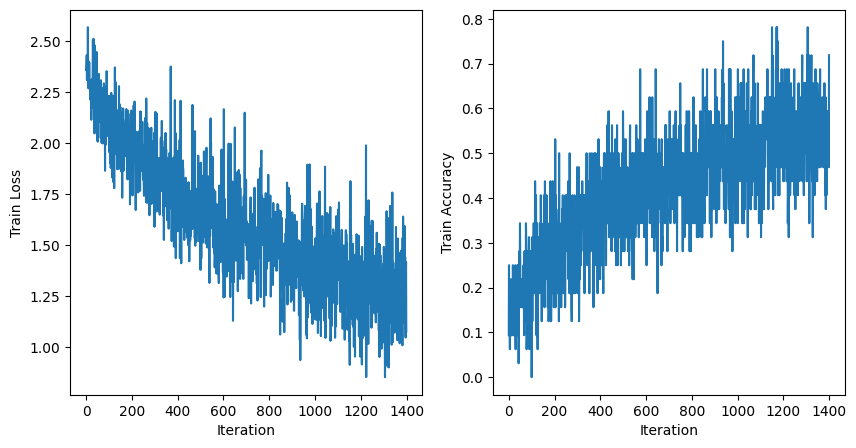

Epoch 10/10 - Avg Loss: 1.2683, Avg Acc: 0.5509
--------------------------------------------------


In [28]:
train_audio_clfr(
    model=rnn_raw,
    optimizer=optim,
    train_dataloader=train_dataloader,
    sr=train_dataset.sr,
    num_epochs=10,
    device=device,
    verbose_num_iters=10
)


Посчитаем метрики на валидационном датасете.

In [29]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

/tmp/ipykernel_156625/268887392.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


Val accuracy: 0.4032085561497326


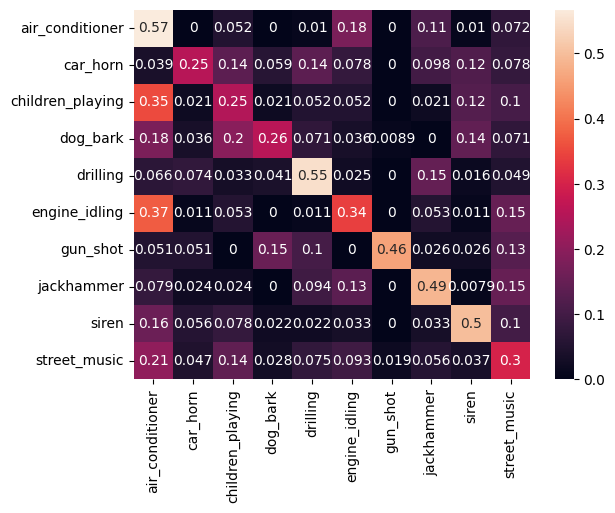

In [30]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина? Да и очень сильно. Ну возможно переобучение и (или) отсутствие регуляризации.

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

<center>
<img src="https://antkillerfarm.github.io/images/img2/Spectrogram_5.png" height="550">
</center>

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [69]:
from torchaudio.transforms import MelSpectrogram


# референсная функця
def compute_log_melspectrogram_reference(wav_batch, lens, sr, device="cpu"):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

/tmp/ipykernel_156625/268887392.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


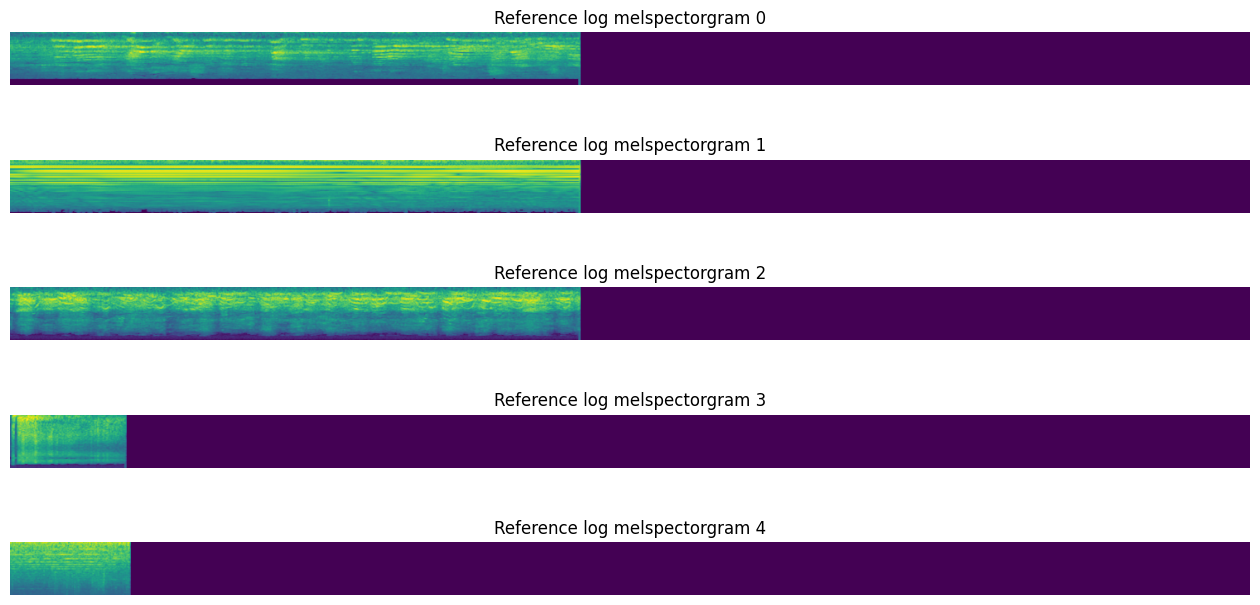

In [70]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами. 

In [71]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [72]:
windows = wav_batch.unfold(dimension=1, size=win_length, step=hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

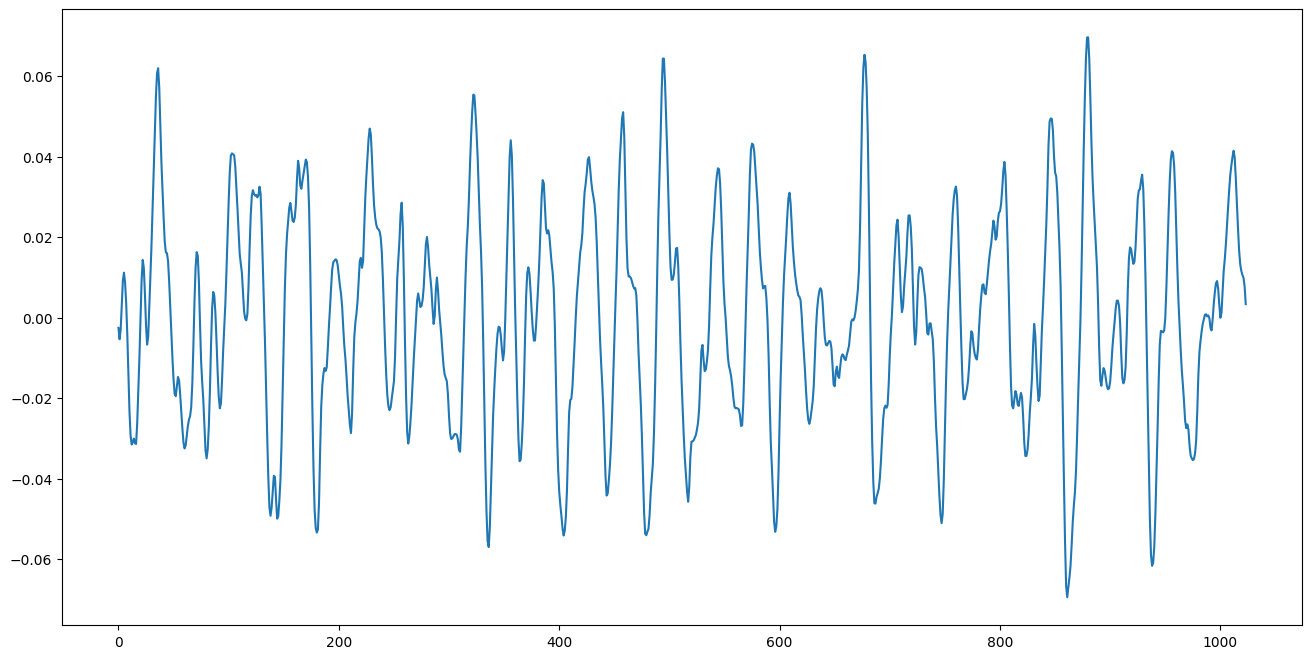

In [73]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [74]:
filter = torch.hann_window(win_length, periodic=False, device=wav_batch.device)
windows_with_applied_filter = windows * filter[None, None, :]

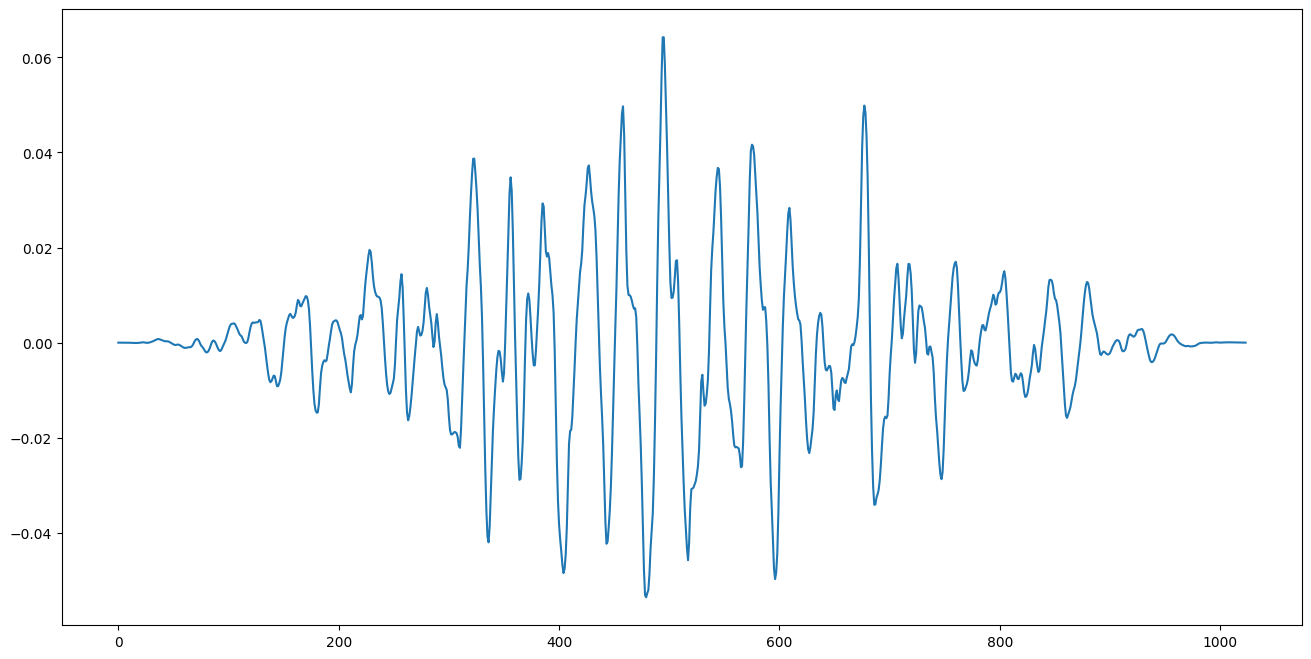

In [75]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [76]:
fft_features = torch.fft.fft(windows_with_applied_filter, n=n_fft)
fft_features = fft_features[..., :n_fft//2+1]
fft_magnitudes = torch.abs(fft_features**2)
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [77]:
melscale = T.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_fft//2 + 1)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

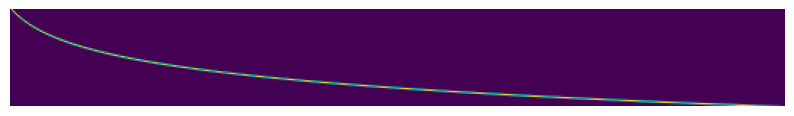

In [78]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [79]:
mel_spectrogram = melscale(fft_magnitudes.transpose(1, 2))
assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [80]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(min=1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

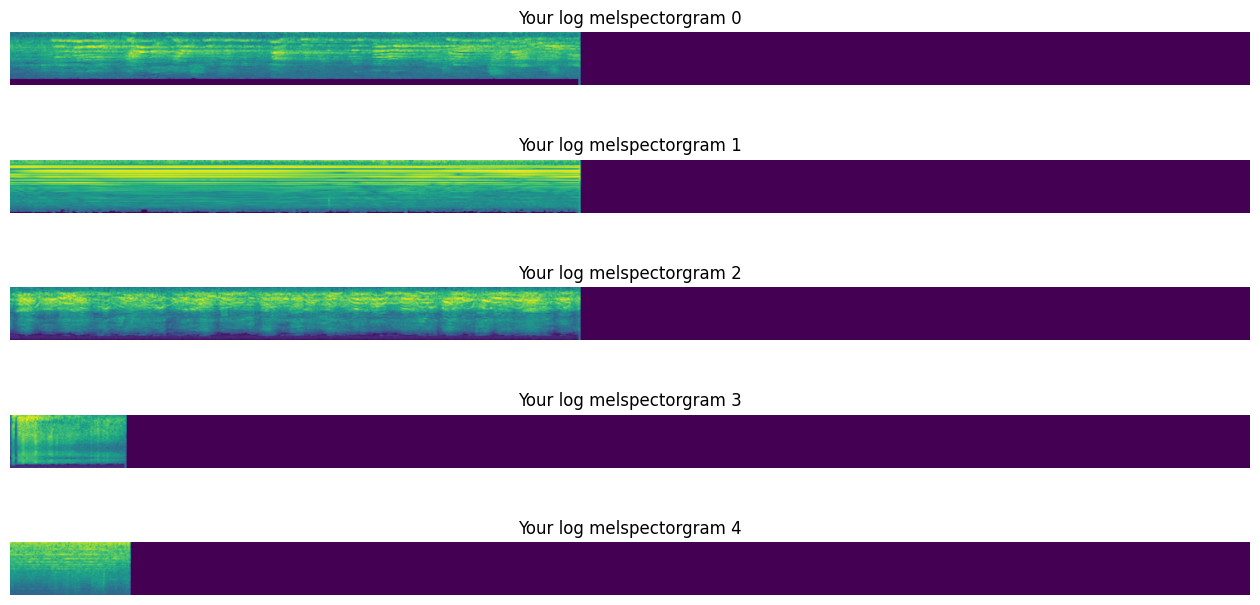

In [81]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [82]:

def compute_log_melspectrogram(wav_batch, lens, sr, device="cpu"):
    n_fft = 1024
    win_length = 1024
    hop_length = 256
    n_mels = 64


    windows = wav_batch.unfold(dimension=1, size=win_length, step=hop_length)
    hann = torch.hann_window(win_length, periodic=True, device=wav_batch.device)
    windows = windows * hann.view(1, 1, -1)
    fft_features = torch.fft.rfft(windows, n=n_fft)

    power_spec = torch.abs(fft_features)**2

    melscale = torchaudio.transforms.MelScale(
        n_mels=n_mels,
        sample_rate=sr,
        n_stft=n_fft // 2 + 1,
    ).to(device)
    mel_spectrogram = melscale(power_spec.transpose(1, 2))

    logmel_spectrogram = torch.log(mel_spectrogram.clamp(min=1e-5))

    new_lens = lens // hop_length

    return logmel_spectrogram, new_lens

Финальная проверка.

In [83]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5
)


## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>

**За реализацию архитектуры дается 0.5 балла.**

In [99]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.rnn = nn.LSTM(
            input_size=64,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * hidden * num_layers, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, lens):
    
        x = x.transpose(1, 2)
        
        out, (h_n, c_n) = self.rnn(x)
        h_n = h_n.transpose(0, 1)
        
        h_n = h_n.reshape(x.shape[0], -1)

        logits = self.final_mlp(h_n)
        return logits

In [100]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

Epoch 10, Iteration 1400 - Loss: 0.6387, Acc: 0.6562


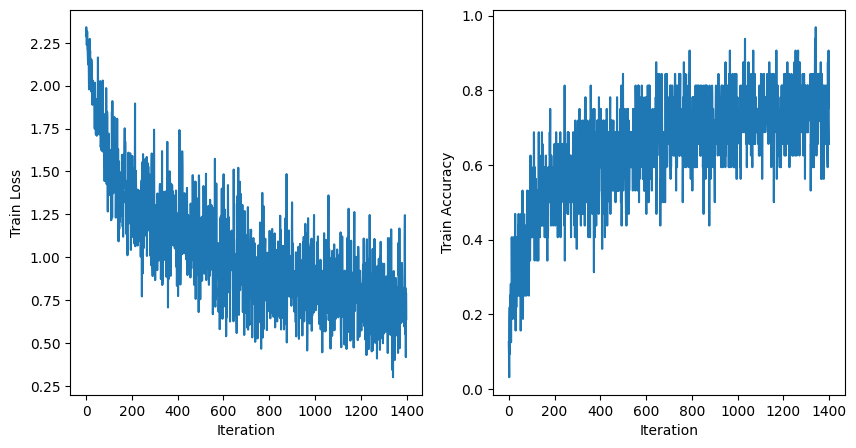

Epoch 10/10 - Avg Loss: 0.7471, Avg Acc: 0.7438
--------------------------------------------------


In [101]:
train_audio_clfr(
    rnn_mel,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

/tmp/ipykernel_156625/268887392.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


Val accuracy: 0.7475935828877005


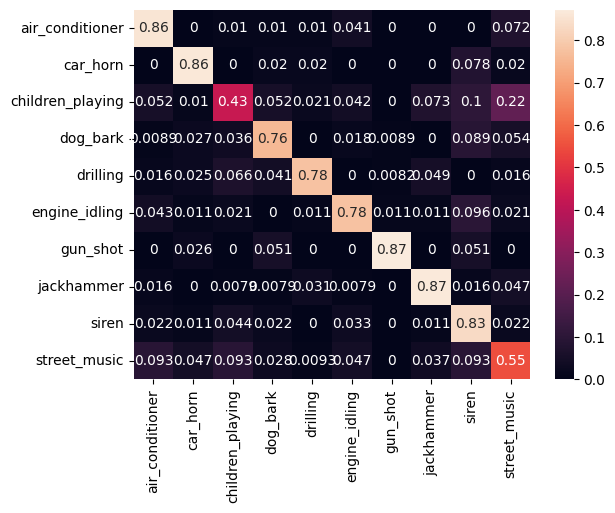

In [102]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [103]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )


        self.final_mlp = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [104]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 20, Iteration 2800 - Loss: 0.0115, Acc: 1.0000


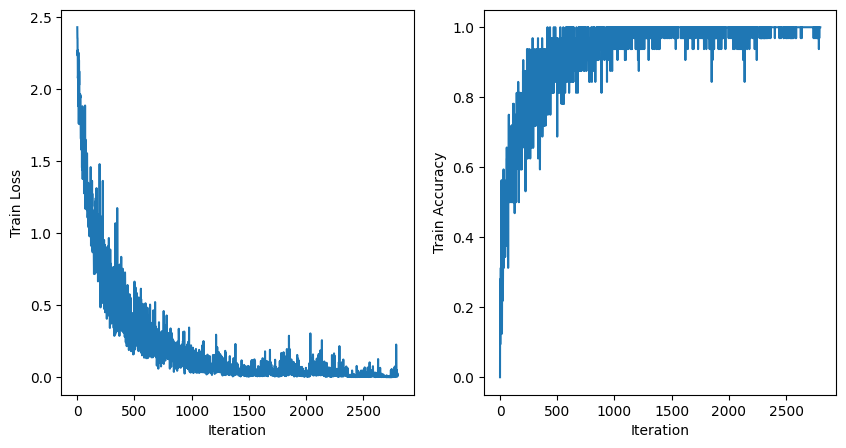

Epoch 20/20 - Avg Loss: 0.0113, Avg Acc: 0.9978
--------------------------------------------------


In [105]:
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=20,
)

Avg Acc: 0.9978 это явно перебор, но 0.85 на валидации есть, так что в целом...


**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

/tmp/ipykernel_156625/268887392.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


Val accuracy: 0.8983957219251337


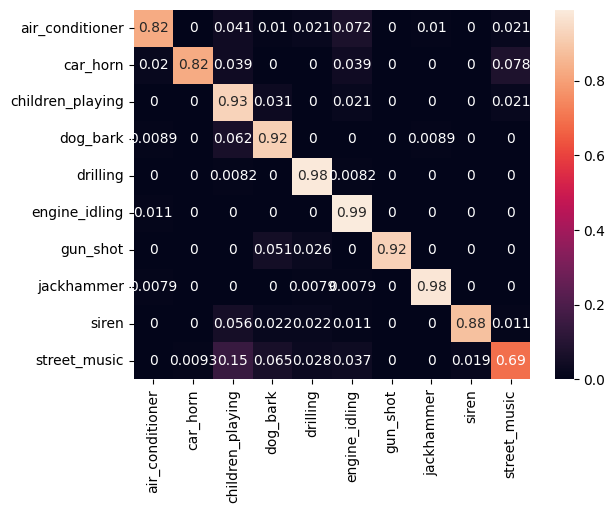

In [106]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [107]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value="mean",
        n_freq_masks=2,
        n_time_masks=2,
        max_freq=10,
        max_time=50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        B, F, T = spect.shape
        for i in range(B):

            if isinstance(self.filling_value, str):
                if self.filling_value == "mean":
                    v = spect[i].mean()
                elif self.filling_value == "min":
                    v = spect[i].min()
                elif self.filling_value == "max":
                    v = spect[i].max()
                else:
                    raise ValueError(f"Unsupported filling_value: {self.filling_value}")
            else:
                v = self.filling_value


            for _ in range(self.n_freq_masks):

                f_mask = random.randint(0, self.max_freq)
                if f_mask == 0:
                    continue
                f0 = random.randint(0, max(F - f_mask, 0))
                spect[i, f0:f0+f_mask, :] = v

            for _ in range(self.n_time_masks):
                t_mask = random.randint(0, self.max_time)
                if t_mask == 0:
                    continue

                t0 = random.randint(0, max(T - t_mask, 0))
                spect[i, :, t0:t0+t_mask] = v

        return spect, lens

/tmp/ipykernel_156625/268887392.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


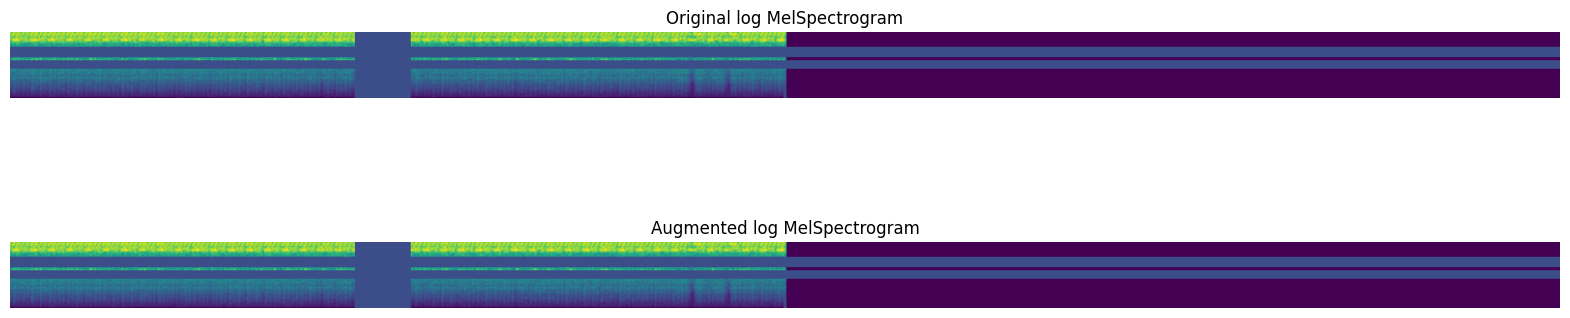

In [108]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [109]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 20, Iteration 2800 - Loss: 0.1563, Acc: 0.9688


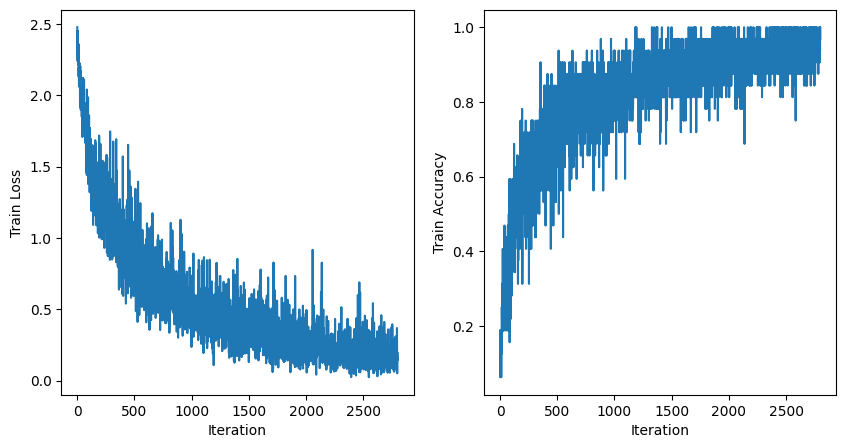

Epoch 20/20 - Avg Loss: 0.1722, Avg Acc: 0.9473
--------------------------------------------------


In [110]:
# обучим модель на данных с аугментациями
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(),
    num_epochs=20,
)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

/tmp/ipykernel_156625/268887392.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


Val accuracy: 0.9165775401069519


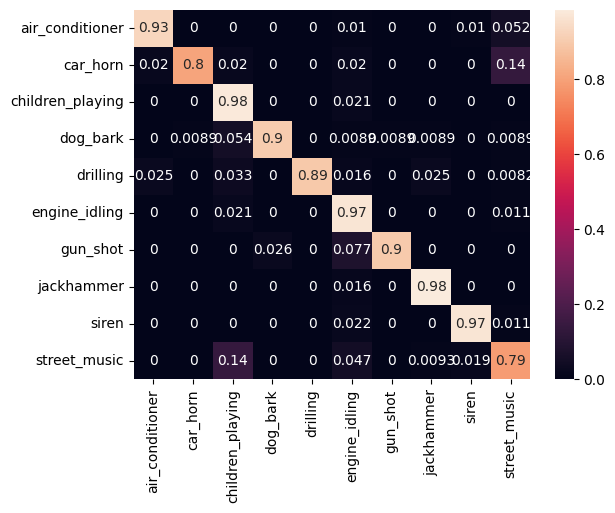

In [111]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)